In [276]:
import pandas as pd
import numpy as np

import random
import itertools
import pickle
from collections import OrderedDict, Counter

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns
sns.set()

# MODELS

from xgboost import XGBClassifier

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold, KFold
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, \
                                  VotingClassifier, \
                                  AdaBoostClassifier, BaggingRegressor


from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score, \
                            accuracy_score, roc_auc_score, make_scorer,\
                            confusion_matrix, precision_recall_curve, roc_curve

# MANAGING CLASS IMBALANCE

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler # don't use this
from imblearn.pipeline import Pipeline, make_pipeline


# Notebook visuals

from mlxtend.plotting import plot_decision_regions
from mlxtend.classifier import StackingClassifier


plt.style.use('ggplot')
sns.set_style("whitegrid")
%matplotlib inline
%pylab inline
%config InlineBackend.figure_formats = ['retina']
%config InlineBackend.figure_format = 'svg' 

from ipywidgets import interactive, FloatSlider

# Make better use of Jupyter Notebook cell width

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

Populating the interactive namespace from numpy and matplotlib


//anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'interactive']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Step 0: Pick the metric for this project
- **Recall** because the cost of running a failed experiment is relatively low but the cost of missing out on a potential great recipe is high.

# Step 1: Import data and take a look

In [201]:
with open('eda_1.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1099 entries, 21 to 73816
Data columns (total 9 columns):
OG               1099 non-null float64
BoilSize         1099 non-null float64
BoilTime         1099 non-null int64
BoilGravity      1099 non-null float64
Efficiency       1099 non-null float64
MashThickness    1099 non-null float64
PitchRate        1099 non-null float64
PrimaryTemp      1099 non-null float64
OK               1099 non-null int64
dtypes: float64(7), int64(2)
memory usage: 85.9 KB


In [203]:
df.head()

,OG,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,PitchRate,PrimaryTemp,OK
21,1.084,51.10,60,1.075,90.0,1.25,1.00,20.56,1
141,1.049,41.64,60,1.044,85.0,1.25,0.75,18.33,1
249,1.069,28.39,90,1.055,85.0,1.75,0.75,19.44,1
312,1.076,7.10,75,1.044,85.0,2.75,1.00,19.00,1
327,1.069,87.06,60,1.063,82.0,1.50,0.75,20.56,1


### 'OK' is the target, and its about 7.5%/92.5% imbalanced split

In [204]:
df['OK'].value_counts()

1    876
0    223
Name: OK, dtype: int64

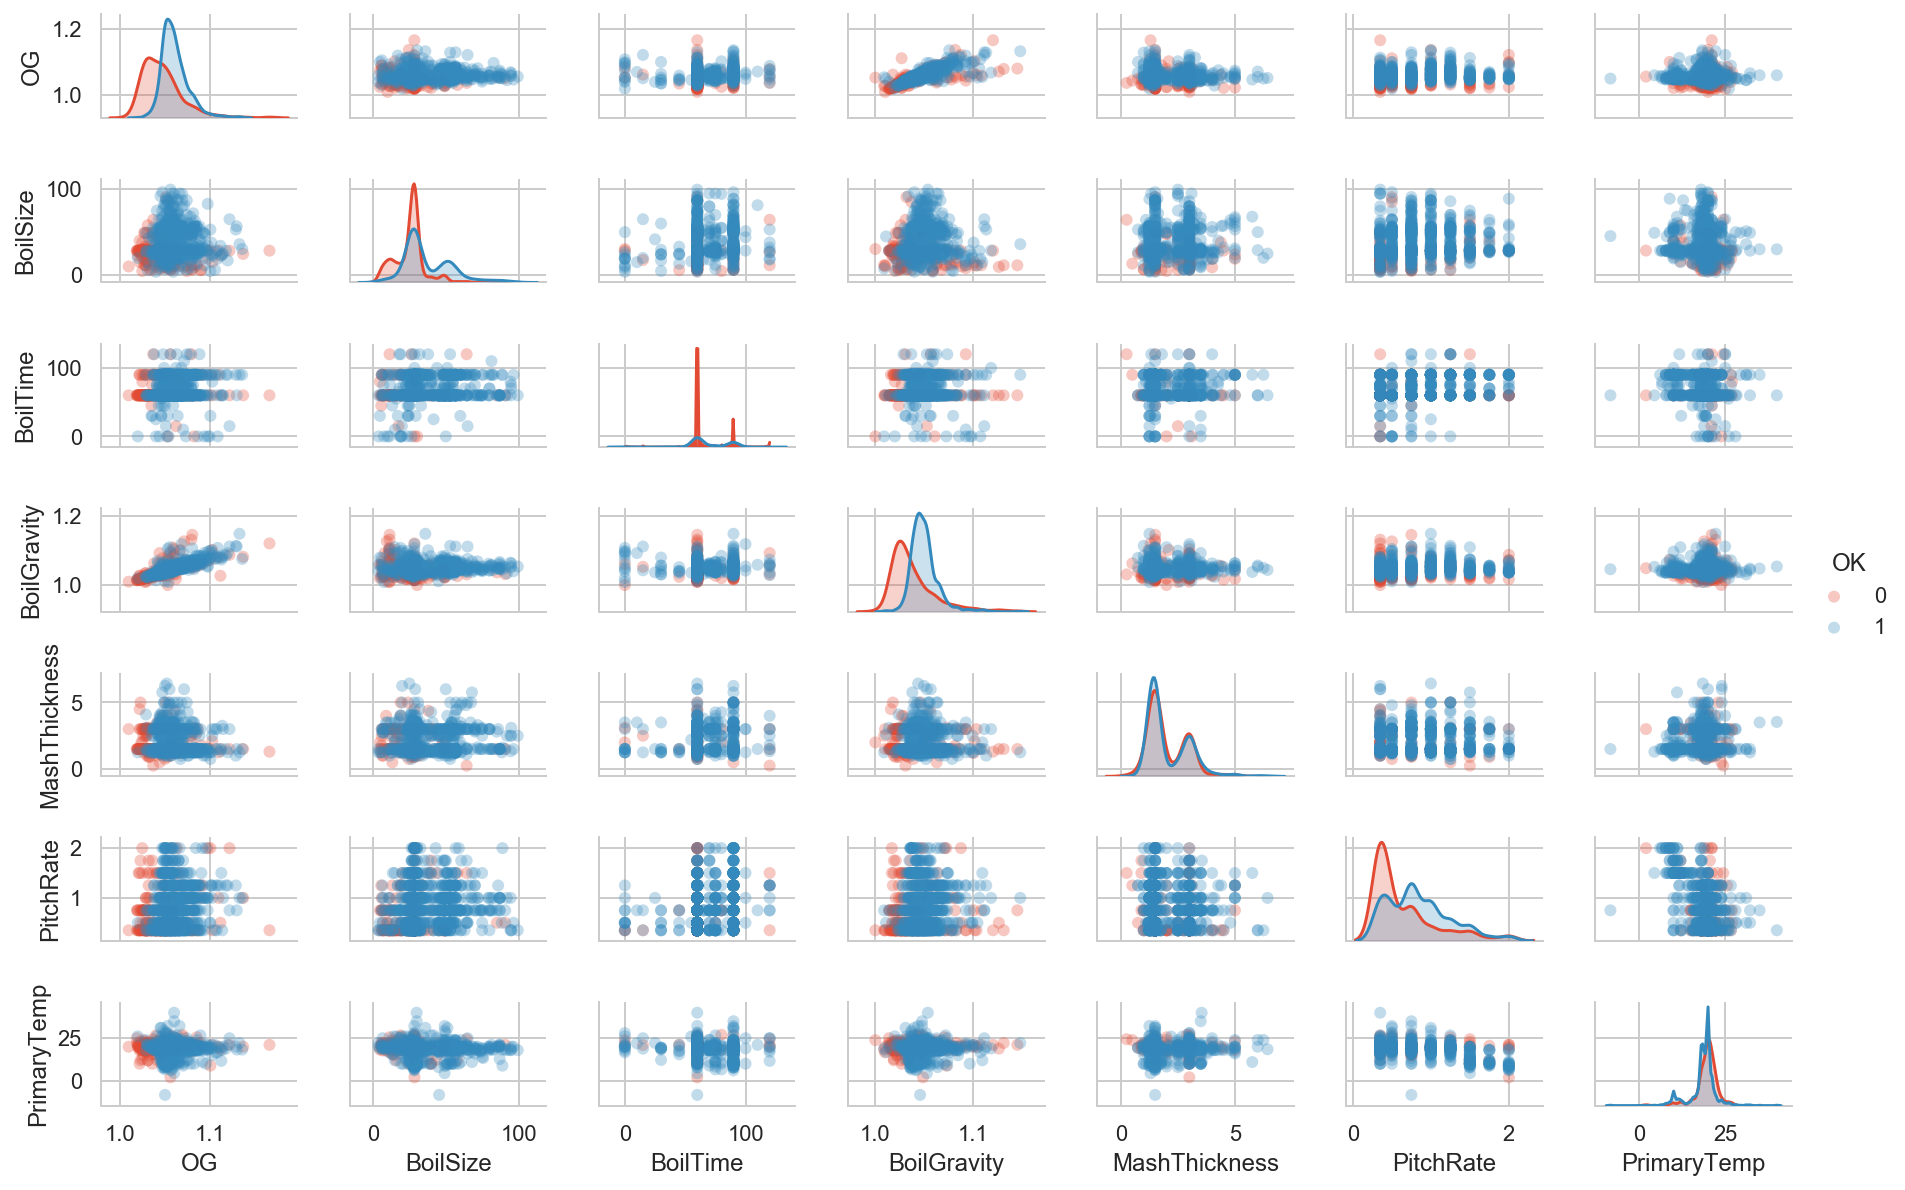

In [206]:
sns.pairplot(df, vars = df.drop(['OK', 'Efficiency'], axis = 1), plot_kws=dict(alpha=.3, edgecolor='none'), hue = 'OK', height=1.2, aspect=1.5);

## Guesses for which features will matter based on pairplot histograms:
- OG
- BoilSize
- BoilGravity
- PitchRate

# Step 2: Do a train test split and keep the test data far away from any modeling
- Stratification is OK to do, and in fact recommended, at this juncture
- Scale the data upfront

In [207]:
X = df.drop('OK', axis = 1)
y = df["OK"].astype(float).values

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
X_trainval, y_trainval = np.array(X_trainval), np.array(y_trainval)

print(X_trainval.shape)
print(y_trainval.shape)

(879, 8)
(879,)


# Step 3: Baseline models

### Models and their associated parameters that can be modified

In [277]:

lrg = LogisticRegression(solver= 'saga', C=1000)
# solver, C, threshold
lrg_params = {'solver': ['saga', 'liblinear', 'lbfgs'], 'C': np.arange(0, 1000, 50)}



rfc = RandomForestClassifier(n_estimators=50, max_depth=4, random_state=42)
# n_estimators, max_depth, random_state



dtc = DecisionTreeClassifier(max_depth = 4)
# n_estimators, max_depth



svm = SVC(kernel = 'linear')
# C
svm_par = {'C': [0.001, 0.01, 0.1, 10, 100, 1000]}



svc = SVC(kernel = 'rbf', gamma = 'auto')
# kernel, gamma, degree (if polynomial), C, cache_size, max_iter



gnb = GaussianNB()



knn = KNeighborsClassifier(n_neighbors=5)
# n_neighbors, weights



sgd = SGDClassifier()
# alpha, l1_ratio



xgb = XGBClassifier()


abc = AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0, n_estimators=50, random_state=None)


etc = ExtraTreesClassifier(n_estimators=100)




models = [lrg, rfc, dtc, svm, svc, gnb, knn, sgd, xgb, abc, etc]
model_names = ['lrg', 'rfc', 'dtc', 'svm', 'svc', 'gnb', 'knn', 'sgd', 'xgb', 'abc', 'etc']



In [295]:
kf = KFold(n_splits=5, random_state=42)

In [296]:
recall_list = []
auc_list = []

for model in models:
    
    for train_ind, val_ind in kf.split(X_trainval,y_trainval):
    
        X_train, y_train = X_trainval[train_ind], y[train_ind]
        X_val, y_val = X_trainval[val_ind], y[val_ind] 
    
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    

    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    recall_list.append(round((recall_score(y_val, y_pred)), 2))
    auc_list.append(round((roc_auc_score(y_val, y_pred)), 2))

    print(confusion_matrix(y_val, y_pred))


[[  0  32]
 [  0 143]]
[[  0  32]
 [  0 143]]
[[  1  31]
 [  1 142]]
[[  0  32]
 [  0 143]]
[[  0  32]
 [  0 143]]
[[  0  32]
 [  0 143]]
[[  5  27]
 [  8 135]]
[[  7  25]
 [ 16 127]]
[[  1  31]
 [  3 140]]
[[  0  32]
 [  5 138]]
[[  2  30]
 [  6 137]]


In [289]:
print(list(zip(model_names, auc_list, recall_list)))

[('lrg', 0.5, 1.0), ('rfc', 0.5, 1.0), ('dtc', 0.51, 0.99), ('svm', 0.5, 1.0), ('svc', 0.5, 1.0), ('gnb', 0.5, 1.0), ('knn', 0.55, 0.94), ('sgd', 0.55, 0.92), ('xgb', 0.51, 0.98), ('abc', 0.48, 0.97), ('etc', 0.51, 0.95)]


## Perfect predictions means that we're classifying *everything* as a class 0! Time to balance

# Step 4: Balancing the data

In [303]:
recall_list_ad = []
auc_list_ad = []

for model in models:
    
    for train_ind, val_ind in kf.split(X_trainval,y_trainval):
    
        X_train, y_train = X_trainval[train_ind], y[train_ind]
        X_val, y_val = X_trainval[val_ind], y[val_ind] 
    
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    
    X_train_scaled_adasyn, y_train_adasyn = ADASYN(random_state = 42).fit_sample(X_train_scaled, y_train)

    model.fit(X_train_scaled_adasyn, y_train_adasyn)
    y_pred = model.predict(X_val_scaled)
    recall_list_ad.append(round((recall_score(y_val, y_pred)), 2))
    auc_list_ad.append(round((roc_auc_score(y_val, y_pred)), 2))
    print(confusion_matrix(y_val, y_pred))

[[12 20]
 [65 78]]
[[  8  24]
 [ 40 103]]
[[16 16]
 [69 74]]
[[13 19]
 [76 67]]
[[16 16]
 [60 83]]
[[12 20]
 [85 58]]
[[18 14]
 [54 89]]
[[11 21]
 [54 89]]
[[  6  26]
 [ 25 118]]
[[ 11  21]
 [ 33 110]]
[[  9  23]
 [ 13 130]]


In [304]:
print(list(zip(model_names, auc_list_ad, recall_list_ad)))

[('lrg', 0.46, 0.55), ('rfc', 0.49, 0.72), ('dtc', 0.51, 0.52), ('svm', 0.44, 0.47), ('svc', 0.54, 0.58), ('gnb', 0.39, 0.41), ('knn', 0.59, 0.62), ('sgd', 0.48, 0.62), ('xgb', 0.51, 0.83), ('abc', 0.56, 0.77), ('etc', 0.6, 0.91)]


In [305]:
Counter(y_train_adasyn)

Counter({1.0: 563, 0.0: 566})

In [306]:
recall_list_smote = []
auc_list_smote = []

for model in models:
    
    for train_ind, val_ind in kf.split(X_trainval,y_trainval):
    
        X_train, y_train = X_trainval[train_ind], y[train_ind]
        X_val, y_val = X_trainval[val_ind], y[val_ind] 
    
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    
    X_train_scaled_smote, y_train_smote = SMOTE(random_state = 42).fit_sample(X_train_scaled, y_train)
    model.fit(X_train_scaled_smote, y_train_smote)
    y_pred = model.predict(X_val_scaled)
    recall_list_smote.append(round((recall_score(y_val, y_pred)), 2))
    auc_list_smote.append(round((roc_auc_score(y_val, y_pred)), 2))
    print(confusion_matrix(y_val, y_pred))
    print('\n')

[[13 19]
 [67 76]]


[[ 8 24]
 [44 99]]


[[17 15]
 [65 78]]


[[18 14]
 [72 71]]


[[17 15]
 [54 89]]


[[13 19]
 [87 56]]


[[17 15]
 [56 87]]


[[18 14]
 [87 56]]


[[  8  24]
 [ 22 121]]


[[ 12  20]
 [ 34 109]]


[[  6  26]
 [ 13 130]]




In [307]:
print(list(zip(model_names, auc_list_smote, recall_list_smote)))

[('lrg', 0.47, 0.53), ('rfc', 0.47, 0.69), ('dtc', 0.54, 0.55), ('svm', 0.53, 0.5), ('svc', 0.58, 0.62), ('gnb', 0.4, 0.39), ('knn', 0.57, 0.61), ('sgd', 0.48, 0.39), ('xgb', 0.55, 0.85), ('abc', 0.57, 0.76), ('etc', 0.55, 0.91)]


In [308]:
print(list(zip(model_names, auc_list_ad, recall_list_ad)))

[('lrg', 0.46, 0.55), ('rfc', 0.49, 0.72), ('dtc', 0.51, 0.52), ('svm', 0.44, 0.47), ('svc', 0.54, 0.58), ('gnb', 0.39, 0.41), ('knn', 0.59, 0.62), ('sgd', 0.48, 0.62), ('xgb', 0.51, 0.83), ('abc', 0.56, 0.77), ('etc', 0.6, 0.91)]


In [286]:
Counter(y_train_smote)

Counter({1.0: 561, 0.0: 561})

# Step 5: Summarize what was learned from baseline modeling of balanced and unbalanced data
- Without balancing, the model just predicted no class 0's
- With balancing, things changed a little bit
- SVM, SVC, knn, abc, maybe xbb all seem like contenders

# Step 6: Explore many model parameters, see if changes pop up
- All the parameters that have been used so far are *fully* arbitrary

In [ ]:
lrg = LogisticRegression(solver= 'saga', C=1000)
# solver, C, tol
lrg_params = {'solver': ['saga', 'liblinear', 'lbfgs'], 'C': np.arange(0, 1000, 50)}



rfc = RandomForestClassifier(n_estimators=50, max_depth=4, random_state=42)
# n_estimators, max_depth, random_state



dtc = DecisionTreeClassifier(max_depth = 4)
# n_estimators, max_depth



svm = SVC(kernel = 'linear')
# C
svm_par = {'C': [0.001, 0.01, 0.1, 10, 100, 1000]}



svc = SVC(kernel = 'rbf', gamma = 'auto')
# kernel, gamma, degree (if polynomial), C, cache_size, max_iter



gnb = GaussianNB()



knn = KNeighborsClassifier(n_neighbors=5)
# n_neighbors, weights



sgd = SGDClassifier()
# alpha, l1_ratio



xgb = XGBClassifier()

In [218]:
models = [lrg, rfc, svm, svc, gnb, knn, sgd, xgb]
recall_list_smote = []
auc_list_smote = []

for model in models:
    
    for train_ind, val_ind in kf.split(X_trainval,y_trainval):
    
        X_train, y_train = X_trainval[train_ind], y[train_ind]
        X_val, y_val = X_trainval[val_ind], y[val_ind] 
    
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
    
    X_train_smote, y_train_smote = SMOTE(random_state = 42).fit_sample(X_train_scaled, y_train)
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_val_scaled)
    recall_list_smote.append(round((recall_score(y_val, y_pred)), 2))
    auc_list_smote.append(round((roc_auc_score(y_val, y_pred)), 2))
    print(confusion_matrix(y_val, y_pred))
    print('\n')

[[15 15]
 [69 76]]


[[  8  22]
 [ 32 113]]


[[23  7]
 [85 60]]


[[18 12]
 [61 84]]


[[21  9]
 [97 48]]


[[18 12]
 [54 91]]


[[12 18]
 [48 97]]


[[  8  22]
 [ 18 127]]




# Step 10: Ensembling